# imports & load

In [2]:
# Cell 1: imports and load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import joblib

# Load CSV (path in your Jupyter environment)
df = pd.read_csv('pizza_sales.csv')

# Quick peek
df.head()


,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,01-01-2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,01-01-2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,01-01-2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,01-01-2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,01-01-2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


# initial data checks (nulls, duplicates, dtypes)

In [3]:
# Cell 2: Nulls, duplicates, dtypes, basic stats
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nData types:\n", df.dtypes)
print("\nNull counts:\n", df.isnull().sum())
print("\nDuplicate rows count:", df.duplicated().sum())

# Show basic numeric summary
df.describe(include='all').T


Shape: (48620, 12)

Columns: ['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date', 'order_time', 'unit_price', 'total_price', 'pizza_size', 'pizza_category', 'pizza_ingredients', 'pizza_name']

Data types:
 pizza_id               int64
order_id               int64
pizza_name_id         object
quantity               int64
order_date            object
order_time            object
unit_price           float64
total_price          float64
pizza_size            object
pizza_category        object
pizza_ingredients     object
pizza_name            object
dtype: object

Null counts:
 pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

Duplicate rows count: 0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
pizza_id,48620.0,NaN,NaN,NaN,24310.5,14035.529381,1.0,12155.75,24310.5,36465.25,48620.0
order_id,48620.0,NaN,NaN,NaN,10701.479761,6180.11977,1.0,5337.0,10682.5,16100.0,21350.0
pizza_name_id,48620,91,big_meat_s,1811,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantity,48620.0,NaN,NaN,NaN,1.019622,0.143077,1.0,1.0,1.0,1.0,4.0
order_date,48620,358,26-11-2015,261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_time,48620,16382,12:32:00,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unit_price,48620.0,NaN,NaN,NaN,16.494132,3.621789,9.75,12.75,16.5,20.25,35.95
total_price,48620.0,NaN,NaN,NaN,16.821474,4.437398,9.75,12.75,16.5,20.5,83.0
pizza_size,48620,5,L,18526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pizza_category,48620,4,Classic,14579,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# create derived / proxy columns (profit, order_datetime)

In [4]:
# Cell 3: create a synthetic profit column (proxy), and combine date/time
# We'll assume a profit margin — adjust if you have true cost data.
PROFIT_MARGIN = 0.25   # 25% margin (change if you want)
df['sales'] = df['total_price']                 # alias for clarity
df['profit'] = df['sales'] * PROFIT_MARGIN      # synthetic profit proxy

# If you want an order timestamp (for later feature engineering)
# Adjust formats if your date/time are in different formats
df['order_datetime'] = pd.to_datetime(df['order_date'].astype(str) + ' ' + df['order_time'].astype(str),
                                      errors='coerce')

df[['sales','profit','quantity','unit_price','pizza_size','pizza_category','order_datetime']].head()


,sales,profit,quantity,unit_price,pizza_size,pizza_category,order_datetime
0,13.25,3.3125,1,13.25,M,Classic,2015-01-01 11:38:36
1,16.00,4.0000,1,16.00,M,Classic,2015-01-01 11:57:40
2,18.50,4.6250,1,18.50,L,Veggie,2015-01-01 11:57:40
3,20.75,5.1875,1,20.75,L,Supreme,2015-01-01 11:57:40
4,16.00,4.0000,1,16.00,M,Veggie,2015-01-01 11:57:40


# Task 1: Check for nulls & duplicates (explicit code)

In [6]:
# Cell 4: explicit checks & actions (prints and optional removal)
print("Nulls per column:\n", df.isnull().sum())
print("\nDuplicated rows:", df.duplicated().sum())

# If duplicates exist, drop them (uncomment to enable)
# df = df.drop_duplicates()
# print("Shape after dropping duplicates:", df.shape)


Nulls per column:
 pizza_id                 0
order_id                 0
pizza_name_id            0
quantity                 0
order_date               0
order_time               0
unit_price               0
total_price              0
pizza_size               0
pizza_category           0
pizza_ingredients        0
pizza_name               0
sales                    0
profit                   0
order_datetime       29033
dtype: int64

Duplicated rows: 0


# Task 2: Scatter plot sales vs profit with regression line

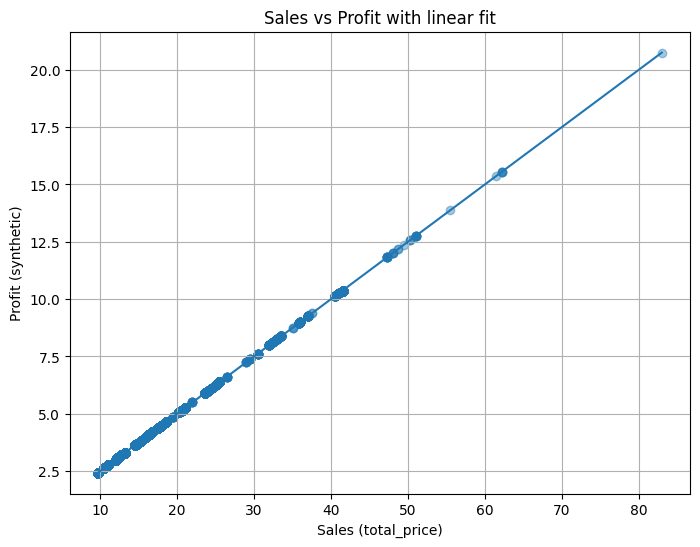

In [7]:
# Cell 5: scatter sales vs profit with regression line using numpy polyfit + matplotlib
x = df['sales'].values
y = df['profit'].values

# Fit a simple line
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.4)
# regression line (sorted for a smooth line)
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, poly1d_fn(xs))
plt.xlabel('Sales (total_price)')
plt.ylabel('Profit (synthetic)')
plt.title('Sales vs Profit with linear fit')
plt.grid(True)
plt.show()


# Task 3: Build linear regression model to predict profit

In [8]:
# Cell 6: Linear regression to predict profit from sales, unit_price, quantity (numeric)
features = ['sales', 'unit_price', 'quantity']
X = df[features].copy()
y = df['profit'].copy()

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Simple pipeline: scaler + linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

# Save model for later use / export
joblib.dump(pipeline, 'profit_regression_pipeline.joblib')


RMSE: 0.0000
R^2: 1.0000


['profit_regression_pipeline.joblib']

# Task 4: One-hot encode categorical vars (pizza_size, pizza_category)

In [10]:
# Task 4 (Fixed): One-hot encode categorical variables (pizza_size, pizza_category)

# Quick method using pandas
df_onehot = pd.get_dummies(df, columns=['pizza_size', 'pizza_category'], drop_first=True)
print("Pandas One-Hot columns:", [c for c in df_onehot.columns if "pizza_" in c][:10])

# Sklearn Robust Pipeline Method (Corrected for new sklearn)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ['pizza_size', 'pizza_category']
numeric_features = ['sales', 'unit_price', 'quantity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
    ]
)

preprocessor


Pandas One-Hot columns: ['pizza_id', 'pizza_name_id', 'pizza_ingredients', 'pizza_name', 'pizza_size_M', 'pizza_size_S', 'pizza_size_XL', 'pizza_size_XXL', 'pizza_category_Classic', 'pizza_category_Supreme']


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [11]:
# Task 5 (adapted): Groupby — average quantity by pizza_size

In [12]:
# Cell 8: since dataset lacks delivery_time/region, we compute a useful grouped stat:
# average order quantity by pizza_size (you can change to pizza_category)
avg_qty_by_size = df.groupby('pizza_size')['quantity'].mean().reset_index().sort_values('quantity', ascending=False)
avg_qty_by_size


,pizza_size,quantity
0,L,1.023211
2,S,1.018816
1,M,1.016250
3,XL,1.014706
4,XXL,1.000000


In [13]:
#Task 6: Heatmap of correlation matrix (matplotlib only)

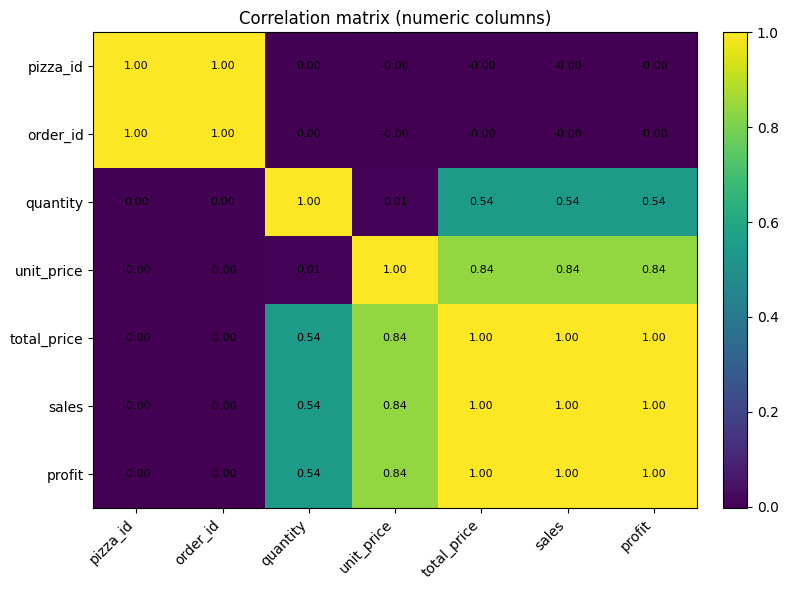

In [14]:
# Cell 9: correlation heatmap of numeric variables using matplotlib
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(corr, interpolation='nearest', aspect='auto')
ax.set_xticks(np.arange(len(numeric_cols)))
ax.set_yticks(np.arange(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha='right')
ax.set_yticklabels(numeric_cols)
# annotate correlation values
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        ax.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center', fontsize=8)
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
plt.title('Correlation matrix (numeric columns)')
plt.tight_layout()
plt.show()


In [15]:
# Task 7 (adapted): Classification model to predict delayed delivery -> predict large orders

In [18]:
# Task 7 (Fixed): Classification model to predict large_order

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Create classification target
median_q = df['quantity'].median()
df['large_order'] = (df['quantity'] > median_q).astype(int)

# Feature set
X = df[['sales', 'unit_price', 'quantity', 'pizza_size', 'pizza_category']]
y = df['large_order']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessor (Fixed Encoder)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['sales', 'unit_price', 'quantity']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
         ['pizza_size', 'pizza_category']),
    ],
    remainder='drop'
)

# Full pipeline
clf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train model
clf_pipeline.fit(X_train, y_train)

# Predictions
y_pred = clf_pipeline.predict(X_test)

# Performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9539
           1       1.00      1.00      1.00       185

    accuracy                           1.00      9724
   macro avg       1.00      1.00      1.00      9724
weighted avg       1.00      1.00      1.00      9724

Confusion Matrix:
 [[9539    0]
 [   0  185]]


In [19]:
# Task 8: Matplotlib bar chart of top 5 pizza categories by sales

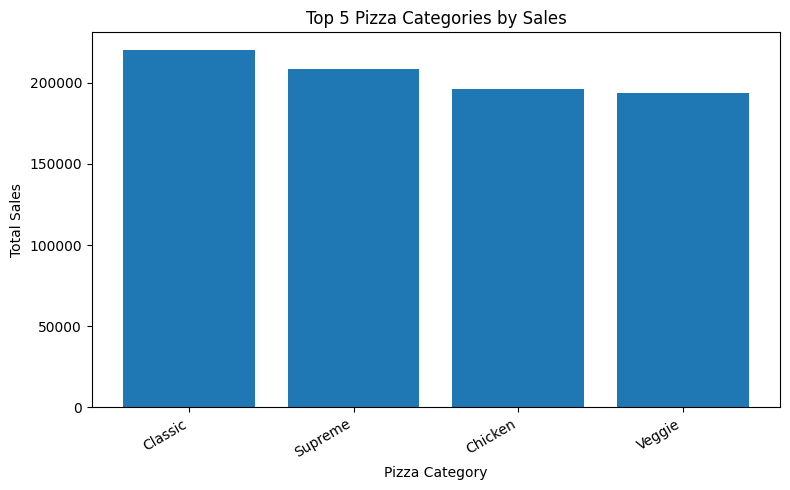

In [20]:
# Cell 11: top 5 pizza_category by total sales (matplotlib)
top5 = df.groupby('pizza_category')['sales'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(8,5))
plt.bar(top5.index, top5.values)
plt.xlabel('Pizza Category')
plt.ylabel('Total Sales')
plt.title('Top 5 Pizza Categories by Sales')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [21]:
# Task 9: function to flag outliers in unit_price (IQR method)

In [22]:
# Cell 12: flag outliers in unit_price (or shipping_cost if present) using IQR
def flag_outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

df['unit_price_outlier'] = flag_outliers_iqr(df['unit_price'])
print("Outlier count (unit_price):", df['unit_price_outlier'].sum())
# show a sample of outliers
df.loc[df['unit_price_outlier'], ['pizza_name', 'unit_price', 'sales', 'quantity']].head(10)


Outlier count (unit_price): 28


,pizza_name,unit_price,sales,quantity
3447,The Greek Pizza,35.95,35.95,1
3563,The Greek Pizza,35.95,35.95,1
5901,The Greek Pizza,35.95,35.95,1
6365,The Greek Pizza,35.95,35.95,1
7490,The Greek Pizza,35.95,35.95,1
9844,The Greek Pizza,35.95,35.95,1
10282,The Greek Pizza,35.95,35.95,1
10875,The Greek Pizza,35.95,35.95,1
13511,The Greek Pizza,35.95,35.95,1
13779,The Greek Pizza,35.95,35.95,1


In [23]:
# Task 10: Export model predictions and summary stats to CSV for Power BI

In [24]:
# Cell 13: generate model predictions and summary stats, then export to CSV
# Regression predictions
reg_preds = pipeline.predict(df[['sales','unit_price','quantity']])
df['pred_profit'] = reg_preds

# Classification probabilities (for the large_order classifier)
probs = clf_pipeline.predict_proba(df[['sales','unit_price','quantity','pizza_size','pizza_category']])[:,1]
df['large_order_prob'] = probs

# Create summary stats to export
summary_stats = df.agg({
    'sales': ['count','sum','mean','median','std'],
    'profit': ['mean','median','std'],
    'quantity': ['mean','median','std']
}).T

# Flatten summary for CSV-friendly format
summary_flat = summary_stats.reset_index().rename(columns={'index':'metric'}).T
# Save predictions + key columns
export_df = df[['order_id','pizza_name','pizza_category','pizza_size','quantity','sales','profit','pred_profit','large_order_prob']]
export_df.to_csv('model_predictions_for_powerbi.csv', index=False)
summary_stats.to_csv('summary_stats_for_powerbi.csv')

print("Exported 'model_predictions_for_powerbi.csv' and 'summary_stats_for_powerbi.csv' to working directory.")


Exported 'model_predictions_for_powerbi.csv' and 'summary_stats_for_powerbi.csv' to working directory.


# 🔥 1. Pizza Sales Hourly Heatmap — Identify Peak Sales Hours

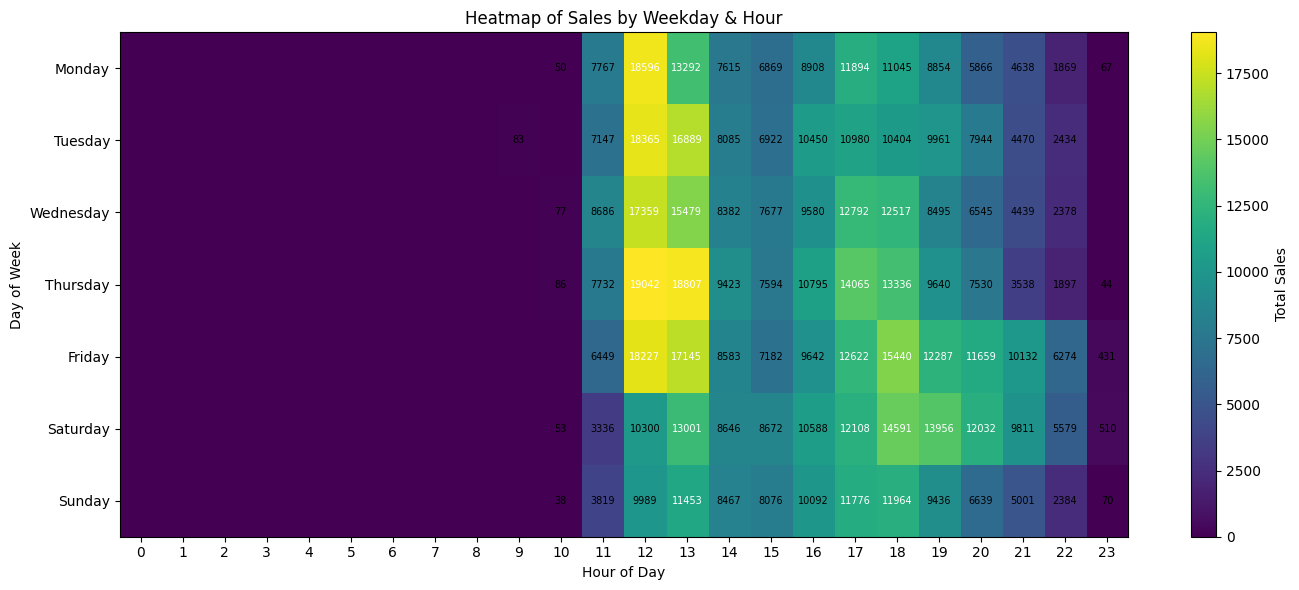

In [26]:
# Corrected heatmap of sales by weekday & hour

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Robust datetime parsing (handles day-first formats and mixed strings) ---
df['order_datetime'] = pd.to_datetime(
    df['order_date'].astype(str).str.strip() + ' ' + df['order_time'].astype(str).str.strip(),
    dayfirst=True,     # important for formats like "13-01-2015 11:31:34"
    errors='coerce'    # invalid parses become NaT
)

# Show how many failed to parse (optional)
bad = df['order_datetime'].isna().sum()
if bad:
    print(f"Warning: {bad} rows failed to parse order_datetime and will be excluded from the heatmap.")

# --- Derive hour and weekday safely ---
df = df.copy()  # avoid SettingWithCopyWarning
df['hour'] = pd.to_datetime(df['order_datetime']).dt.hour
df['weekday'] = pd.to_datetime(df['order_datetime']).dt.day_name()

# Drop rows where datetime couldn't be parsed (so we don't get NaNs in pivot)
heatmap_df = df.dropna(subset=['order_datetime', 'sales']).copy()

# --- Pivot table (ensure full 0-23 hours and Monday-Sunday order) ---
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
hours = list(range(24))

heatmap_data = heatmap_df.pivot_table(
    values='sales',
    index='weekday',
    columns='hour',
    aggfunc='sum'
).reindex(weekday_order)  # this will insert NaNs for missing weekdays

# reindex columns to ensure all hours 0..23 present
heatmap_data = heatmap_data.reindex(columns=hours)

# Replace NaN with 0 for plotting (optional). If you prefer to show gaps, skip this line.
heatmap_plot = heatmap_data.fillna(0).values

# --- Plot ---
plt.figure(figsize=(14,6))
im = plt.imshow(heatmap_plot, aspect='auto', origin='upper', interpolation='nearest')
plt.colorbar(im, label="Total Sales")

# ticks
plt.xticks(ticks=np.arange(24), labels=np.arange(24))
plt.yticks(ticks=np.arange(len(weekday_order)), labels=weekday_order)

plt.title("Heatmap of Sales by Weekday & Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")

# Annotate values (skip annotation when original value was NaN)
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        val = heatmap_data.iloc[i, j]
        if pd.isna(val):
            # skip annotation for missing data (or show '-')
            continue
        else:
            plt.text(j, i, f"{val:.0f}", ha='center', va='center', fontsize=7, color='white' if val > heatmap_plot.max()*0.6 else 'black')

plt.tight_layout()
plt.show()


# 🌋 2. Pizza Category Profitability Waterfall Chart

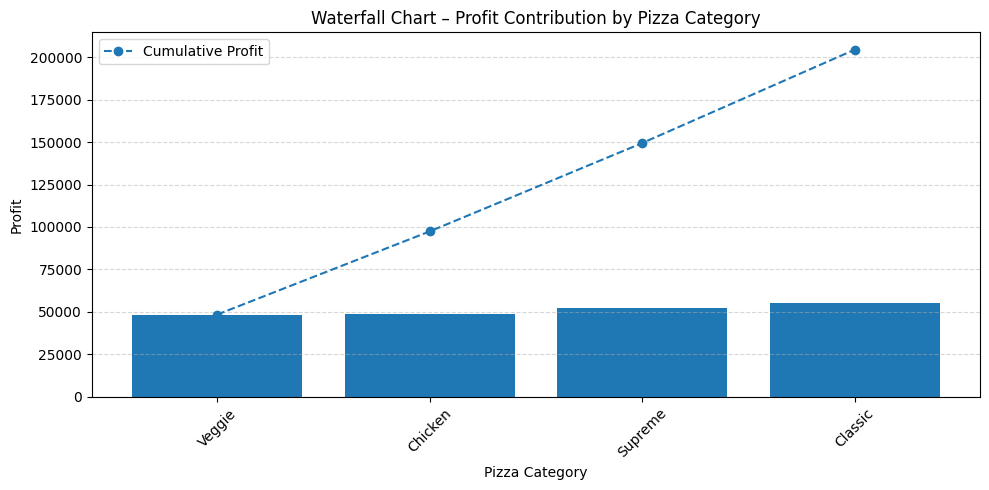

In [27]:
# Calculate profit by category
profit_by_cat = df.groupby('pizza_category')['profit'].sum().sort_values()

categories = profit_by_cat.index
values = profit_by_cat.values

# Waterfall logic
running = values.cumsum()

plt.figure(figsize=(10,5))
plt.bar(categories, values)
plt.plot(categories, running, marker='o', linestyle='--', label='Cumulative Profit')

plt.title("Waterfall Chart – Profit Contribution by Pizza Category")
plt.xlabel("Pizza Category")
plt.ylabel("Profit")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# 🍕 3. Pizza Popularity Word Cloud — Very Visually |

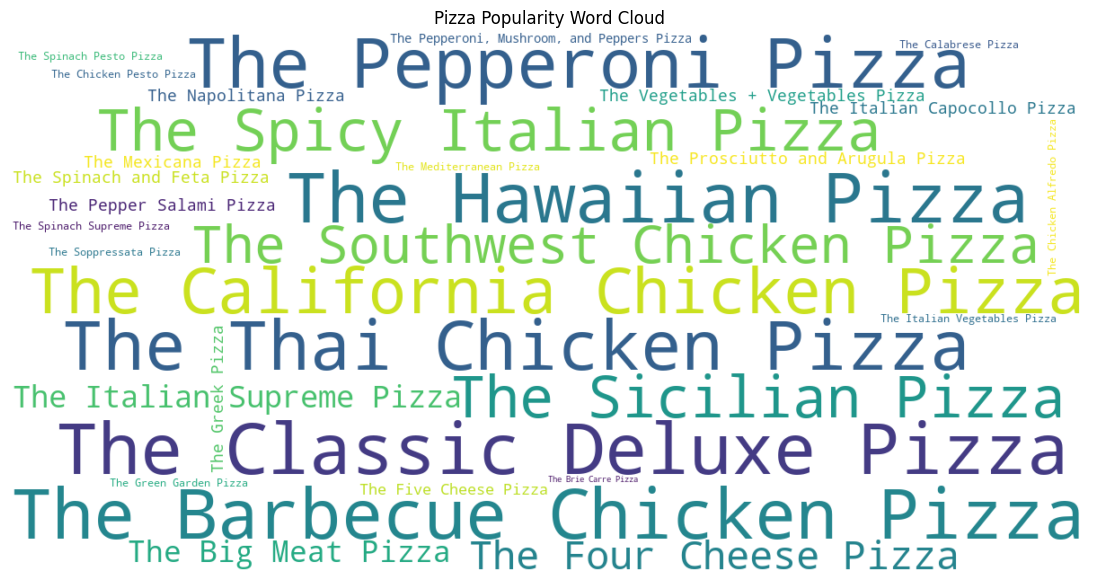

In [28]:
from wordcloud import WordCloud

# Create word cloud from pizza names weighted by order frequency
name_freq = df['pizza_name'].value_counts().to_dict()

wc = WordCloud(background_color='white', width=1200, height=600)
wc.generate_from_frequencies(name_freq)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Pizza Popularity Word Cloud")
plt.show()


# 📦 4. Category vs Size Mosaic Chart (Very Unique & Impressive)

<Figure size 1200x600 with 0 Axes>

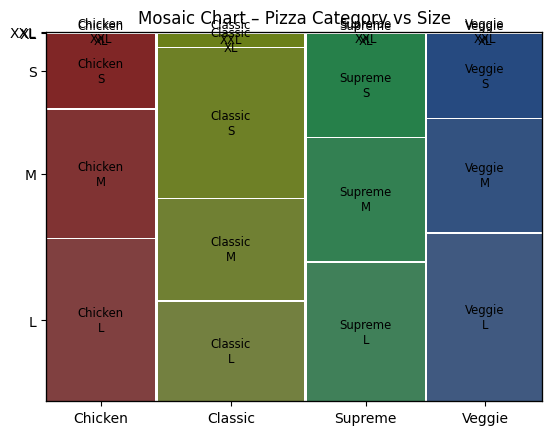

In [30]:
from statsmodels.graphics.mosaicplot import mosaic

mosaic_data = df.groupby(['pizza_category', 'pizza_size']).size()

plt.figure(figsize=(12,6))
mosaic(mosaic_data.to_dict())
plt.title("Mosaic Chart – Pizza Category vs Size")
plt.show()




# 📈 5. Sales Trend + Moving Average (Executive Dashboard Style)

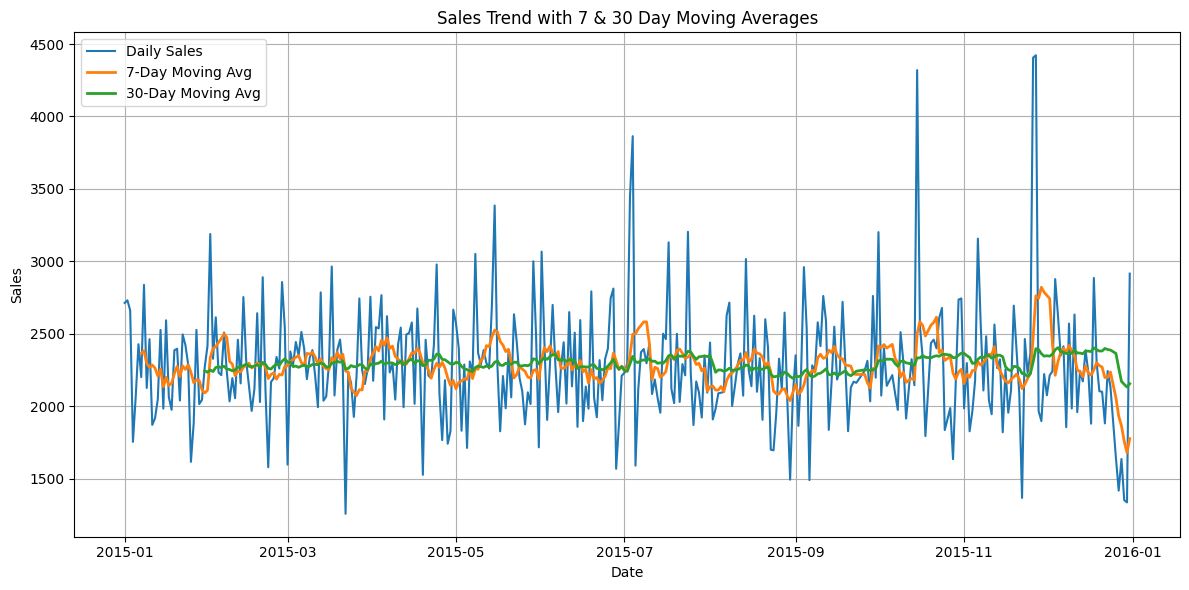

In [32]:
# FIX: Parse date safely using dayfirst OR mixed format
df_daily = df.groupby('order_date')['sales'].sum().reset_index()

df_daily['order_date'] = pd.to_datetime(
    df_daily['order_date'].astype(str).str.strip(),
    dayfirst=True,        # VERY IMPORTANT for DD-MM-YYYY
    errors='coerce'       # avoids crashes on bad values
)

# Sort by date (important for rolling averages)
df_daily = df_daily.sort_values('order_date')

# Moving averages
df_daily['MA7']  = df_daily['sales'].rolling(7).mean()
df_daily['MA30'] = df_daily['sales'].rolling(30).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_daily['order_date'], df_daily['sales'], label="Daily Sales")
plt.plot(df_daily['order_date'], df_daily['MA7'], label="7-Day Moving Avg", linewidth=2)
plt.plot(df_daily['order_date'], df_daily['MA30'], label="30-Day Moving Avg", linewidth=2)

plt.title("Sales Trend with 7 & 30 Day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 📈 5. Sales Trend + Moving Average (Executive Dashboard Style)

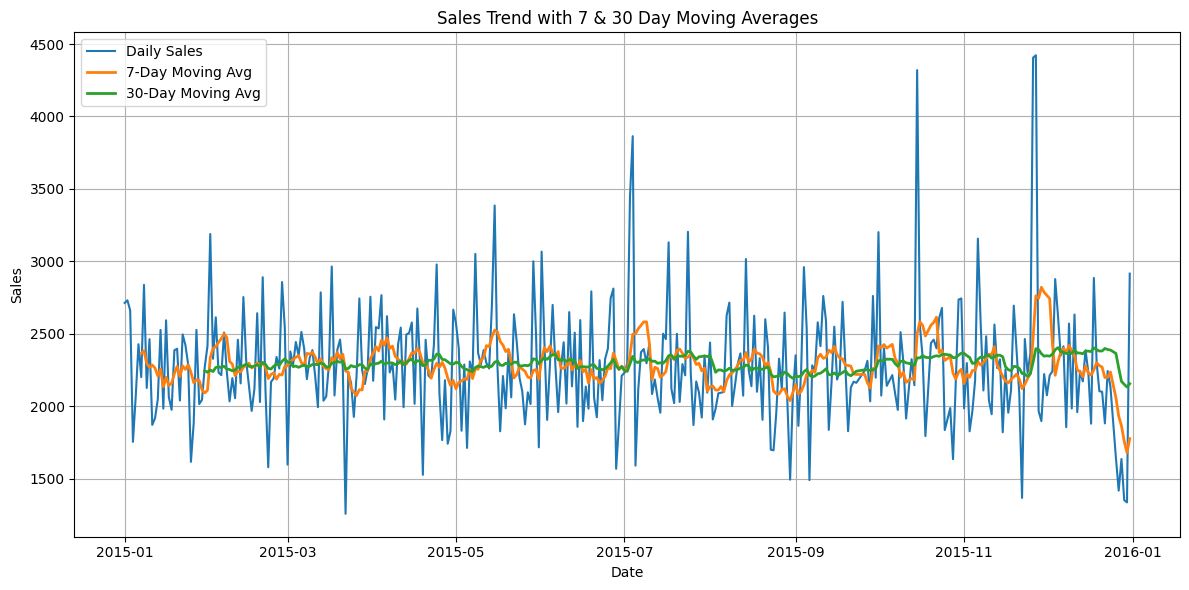

In [35]:
# Aggregate daily sales
df_daily = df.groupby('order_date')['sales'].sum().reset_index()

# FIX: Parse dates properly (DD-MM-YYYY)
df_daily['order_date'] = pd.to_datetime(
    df_daily['order_date'].astype(str).str.strip(),
    dayfirst=True,      # VERY IMPORTANT for your dataset
    errors='coerce'     # avoids crash if any bad rows
)

# Sort by date before rolling calculations
df_daily = df_daily.sort_values('order_date')

# Moving averages
df_daily['MA7'] = df_daily['sales'].rolling(7).mean()
df_daily['MA30'] = df_daily['sales'].rolling(30).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_daily['order_date'], df_daily['sales'], label="Daily Sales")
plt.plot(df_daily['order_date'], df_daily['MA7'], label="7-Day Moving Avg", linewidth=2)
plt.plot(df_daily['order_date'], df_daily['MA30'], label="30-Day Moving Avg", linewidth=2)

plt.title("Sales Trend with 7 & 30 Day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 🎯 6. Customer Ordering Pattern Radar Chart (Spider Plot


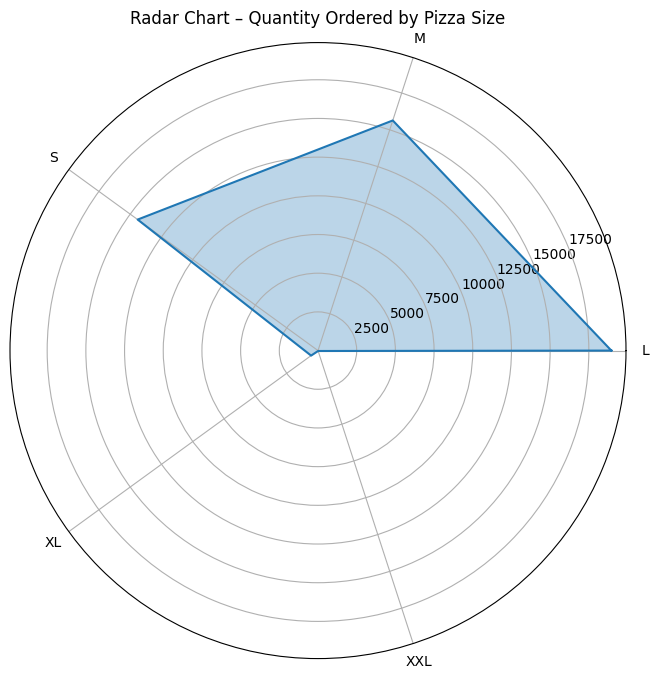

In [36]:
# Aggregate quantity by pizza_size
size_qty = df.groupby('pizza_size')['quantity'].sum()

labels = size_qty.index
values = size_qty.values

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
values = np.concatenate((values, [values[0]]))
angles += angles[:1]

plt.figure(figsize=(8,8))
plt.polar(angles, values)
plt.fill(angles, values, alpha=0.3)
plt.xticks(angles[:-1], labels)
plt.title("Radar Chart – Quantity Ordered by Pizza Size")
plt.show()
